In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal


In [47]:
df = pd.read_csv("faithful.txt", sep="\s+")
X = df.to_numpy()
X.shape

(272, 2)

In [85]:
class EM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization
    """
    
    def __init__(self, n_components, n_iter, tol, seed):
        self.n_components = n_components
        self.n_iter = n_iter
        self.tol = tol
        self.seed = seed

    def fit(self, X):
        
        # data's dimensionality and responsibility vector
        self.n_row, self.n_col = X.shape     
        self.resp = np.zeros((self.n_row, self.n_components))
        
        means = np.array([[3, 80], [3.5, 60]])
        Sigma1 = np.array([[0.1, 0.0], [0.0, 10.0]])
        Sigma2 = np.array([[0.1, 0], [0, 50]])
        shape = 2, 2, 2
        covs = np.full(shape, np.cov(X, rowvar = False))#np.empty(shape, dtype=float)
        covs[0, :, :] = Sigma1
        covs[1,:, :] = Sigma2
        print(covs.shape)
        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(self.n_row, self.n_components, replace = False)
        self.means = means#X[chosen]
        self.weights = np.array([0.5, 0.5]) #np.full(self.n_components, 1 / self.n_components)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, self.n_col, self.n_col
        self.covs = covs# np.full(shape, np.cov(X, rowvar = False))
        print(self.covs[1])
        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      
        
        for i in range(self.n_iter):
            self._do_estep(X)
            self._do_mstep(X)
            log_likelihood_new = self._compute_log_likelihood(X)
           
            if (log_likelihood - log_likelihood_new) <= self.tol:
                print("Final iteration: %d"% i)
                self.converged = True
                break
                
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)
            
        return self
      
    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood
        
        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return self
 
    def _do_mstep(self, X):
        """M-step, update parameters"""
        
        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / self.n_row
        
        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self
    
    
    def _compute_log_likelihood(self, X):
        """manually compute the log likelihood of the current parameter"""
        log_likelihood = 0
        for k in range(self.n_components):
            
            weight = self.weights[k]
            mean = self.means[k]
            cov = self.covs[k]
            cov_inverse = np.linalg.inv(cov)
            term_other = np.log(2 * np.pi) + np.log(np.linalg.det(cov))
            
            for x in X:
                # compute (x-mu)^T * Sigma^{-1} * (x-mu)
                diff = x - mean
                term_exponent = np.dot(diff.T, np.dot(cov_inverse, diff))
            
                # compute loglikelihood contribution for this data point and this cluster             
                log_likelihood += -1 / 2 * (term_other + term_exponent) + np.log(weight)
            
        return log_likelihood

In [73]:
import matplotlib.mlab as mlab

def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.linspace(0,6)
    y = np.linspace(30,100)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1] / (sigmax * sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
    
    plt.title(title)
    plt.tight_layout()

        

(2, 2, 2)
[[ 0.1  0. ]
 [ 0.  50. ]]
Final iteration: 4
True


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.


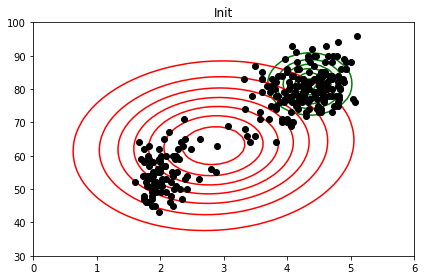

In [86]:
em = EM(n_components=2,n_iter=30, tol=1e-6, seed=4)
em.fit(X)
print(em.converged)
plot_contours(X, em.means, em.covs, 'Init')